# Lane-Emden polytrope equation

We want to solve the Lane-Emden equation:

\begin{equation}
\frac{1}{\xi^2} \frac{d}{d\xi} \left (\xi^2 \frac{d\theta}{d\xi} \right ) = -\theta^n
\end{equation}

using a Runge-Kutta integration.  We will rewrite this as 2 first order equations, taking $y = \theta$, $z = \theta^\prime$:

\begin{eqnarray*}
\frac{dy}{d\xi} &=& z \\
\frac{dz}{d\xi} &=& -\frac{2}{\xi}z - y^n
\end{eqnarray*}

In [1]:
import matplotlib.pyplot as plt
import numpy as np

This is our main class that does the integration.  We initialize it with the polytopic index, and then it will integrate the system for us.  We can then plot it or get
the parameters $\xi_1$ and $-\xi_1^2 d\theta/d\xi |_{\xi_1}$

We estimate the radius, $\xi_1$ each step and make sure that the next step does not take us past that estimate.  This prevents us from having negative $\theta$ values.  Given a point $(\xi_0, y_0)$, and the derivative at that point, $z_0 = dy/d\xi |_{\xi_0}$, we can write the equation of a line as:

\begin{equation}
    y(\xi) - y_0 = z_0 (\xi - \xi_0)
\end{equation}

Then we can ask when does $y$ become zero, finding:

\begin{equation}
    \xi = -\frac{y_0}{z_0} + \xi_0
\end{equation}

This is our estimate of $\xi_1$.  We then make sure our stepsize $h$ is small enough that we do not go beyond this estimate.

In [2]:
class Polytrope:
    """a polytrope of index n"""
    def __init__(self, n, h0=1.e-2, tol=1.e-12):
        self.n = n
        self.xi = []
        self.theta = []
        self.dtheta_dxi = []
        
        self._integrate(h0, tol)

    def _integrate(self, h0, tol):
        """integrate the Lane-Emden system"""

        # our solution vector q = (y, z)
        q = np.zeros(2, dtype=np.float64)
        xi = 0.0

        h = h0

        # initial conditions
        q[0] = 1.0
        q[1] = 0.0

        while h > tol:
            # 4th order RK integration -- first find the slopes
            k1 = self._rhs(xi, q)
            k2 = self._rhs(xi+0.5*h, q+0.5*h*k1)
            k3 = self._rhs(xi+0.5*h, q+0.5*h*k2)
            k4 = self._rhs(xi+h, q+h*k3)

            # now update the solution to the new xi
            q += (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)
            xi += h

            # set the new stepsize--our systems is always convex
            # (theta'' < 0), so the intersection of theta' with the
            # x-axis will always be a conservative estimate of the
            # radius of the star.  Make sure that the stepsize does
            # not take us past that.
            R_est = xi - q[0]/q[1]

            if xi + h > R_est:
                h = -q[0]/q[1]

            # store the solution:
            self.xi.append(xi)
            self.theta.append(q[0])
            self.dtheta_dxi.append(q[1])

        self.xi = np.array(self.xi)
        self.theta = np.array(self.theta)
        self.dtheta_dxi = np.array(self.dtheta_dxi)

    def _rhs(self, xi, q):
        """ the righthand side of the LE system, q' = f"""

        f = np.zeros_like(q)

        # y' = z
        f[0] = q[1]
        
        # for z', we need to use the expansion if we are at xi = 0,
        # to avoid dividing by 0
        if xi == 0.0:
            f[1] = (2.0/3.0) - q[0]**self.n
        else:
            f[1] = -2.0*q[1]/xi - q[0]**self.n

        return f

    def get_params(self):
        """ return the standard polytrope parameters xi_1,
        and [-xi**2 theta']_{xi_1} """
        xi1 = self.xi[-1]
        p2 = -xi1**2 * self.dtheta_dxi[-1]
        return xi1, p2

    def plot(self):
        """ plot the solution """
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(self.xi, self.theta, label=r"$\theta$")
        ax.plot(self.xi, self.theta**self.n, label=r"$\rho/\rho_c$")
        ax.set_xlabel(r"$\xi$")
        ax.legend(frameon=False)
        return fig

We can plot any of the polytrope solutions

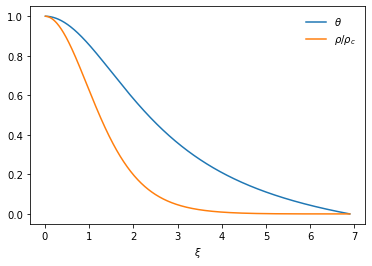

In [3]:
p = Polytrope(3)
fig = p.plot()

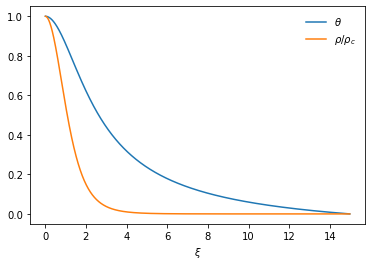

In [4]:
p = Polytrope(4)
fig = p.plot()

Here's a table of the important parameters

In [5]:
for i, nindex in enumerate([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]):
    p = Polytrope(nindex)
    params = p.get_params()
    if i == 0:
        print(f"{'n':4} : {'ξ1':^20} {'-ξ1^2 dθ/dξ |_ξ1':^20}")
    print("{:4} : {:20.10g} {:20.10g}".format(nindex, params[0], params[1]))

n    :          ξ1            -ξ1^2 dθ/dξ |_ξ1  
   0 :          2.449508197           4.89909021
 0.5 :          2.752698045          3.788626506
   1 :          3.141592654          3.141592654
 1.5 :          3.653753736          2.714055127
   2 :          4.352874596          2.411046012
 2.5 :          5.355275459          2.187199565
   3 :           6.89684862          2.018235951
 3.5 :          9.535805346          1.890557093
   4 :          14.97154635          1.797229914
 4.5 :          31.83646326          1.737798868
